In [2]:
import pandas as pd
import numpy as np
from src.env.portfolio_gym import PortfolioGym


import pandas as pd

panel = pd.read_pickle("data/processed/etfs_1m_clean.pkl")

# Sort just in case
panel = panel.sort_index()

# Determine split index (e.g. 80% train)
split_idx = int(len(panel.index) * 0.8)
train_panel = panel.iloc[:split_idx]
test_panel = panel.iloc[split_idx:]

from src.env.portfolio_env import PortfolioEnv

train_env = PortfolioEnv(train_panel, start_equity=1_000_000)
test_env = PortfolioEnv(test_panel, start_equity=1_000_000)






In [2]:
pip install stable-baselines3[extra] gymnasium==1.0.0


  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ---------------------------------------- 0.0/958.1 kB ? eta -:--:--
   ---------- ----------------------------- 262.1/958.1 kB ? eta -:--:--
   -------------------------------- ------- 786.4/958.1 kB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 958.1/958.1 kB 2.2 MB/s  0:00:00
   ---------------------------------------- 0.0/3.5 MB ? eta -:--:--
   --- ------------------------------------ 0.3/3.5 MB ? eta -:--:--
   ------------ --------------------------- 1.0/3.5 MB 3.6 MB/s eta 0:00:01
   --------------------- ------------------ 1.8/3.5 MB 4.4 MB/s eta 0:00:01
   ------------------------------------ --- 3.1/3.5 MB 4.6 MB/s eta 0:00:01
   ---------------------------------------- 3.5/3.5 MB 4.8 MB/s  0:00:00
   ---------------------------------------- 0.0/5.5 M

In [2]:
import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device name:", torch.cuda.get_device_name(0))
    print("CUDA version:", torch.version.cuda)
else:
    print("⚠️ CUDA not detected — running on CPU")


AttributeError: partially initialized module 'torch' has no attribute 'version' (most likely due to a circular import)

In [4]:
!pip uninstall torch torchvision torchaudio -y
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Found existing installation: torch 2.5.1
Uninstalling torch-2.5.1:
  Successfully uninstalled torch-2.5.1


^C


In [3]:
!dir


 Volume in drive C is Acer
 Volume Serial Number is 3E80-FBD3

 Directory of C:\Users\mithi\drl-portfolio-allocation

13/10/2025  13:12    <DIR>          .
11/10/2025  21:37    <DIR>          ..
10/10/2025  03:01                83 .gitignore
11/10/2025  23:38    <DIR>          .ipynb_checkpoints
11/10/2025  11:20    <DIR>          data
13/10/2025  11:37    <DIR>          logs
13/10/2025  12:44    <DIR>          models
11/10/2025  23:38            41,800 notebook_1_ data_wrangling_and_feature_engineering.ipynb
10/10/2025  02:52                26 README.md
11/10/2025  22:56    <DIR>          src
11/10/2025  23:03             8,986 test.ipynb
13/10/2025  13:12            87,369 Untitled.ipynb
               5 File(s)        138,264 bytes
               7 Dir(s)  113,797,763,072 bytes free


In [1]:
import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device name:", torch.cuda.get_device_name(0))
    print("CUDA version:", torch.version.cuda)
else:
    print("⚠️ CUDA not detected — running on CPU")


ImportError: DLL load failed while importing _C: The specified module could not be found.

In [3]:
import numpy as np
import pandas as pd
import torch
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
from src.env.portfolio_gym import PortfolioGym

# ✅ 1️⃣ Load and split data
panel = pd.read_pickle("data/processed/etfs_1m_clean.pkl")
panel = panel.sort_index()

split_idx = int(len(panel.index) * 0.8)
train_panel = panel.iloc[:split_idx]
test_panel = panel.iloc[split_idx:]

print(f"Train size: {len(train_panel)}, Test size: {len(test_panel)}")

# ✅ 2️⃣ Environment factories
def make_train_env():
    env = PortfolioGym(train_panel)
    return Monitor(env)

def make_test_env():
    env = PortfolioGym(test_panel)
    return Monitor(env)

train_env = DummyVecEnv([make_train_env])
eval_env = DummyVecEnv([make_test_env])

# ✅ 3️⃣ Detect GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# ✅ 4️⃣ SAC setup for 2-minute data
model = SAC(
    "MlpPolicy",
    train_env,
    learning_rate=3e-4,
    buffer_size=100_000,
    batch_size=256,
    tau=0.02,
    gamma=0.99,
    train_freq=64,
    gradient_steps=64,
    ent_coef="auto",
    target_entropy="auto",
    verbose=1,
    tensorboard_log="logs/sac_portfolio/",
    device=device  # 👈 enables GPU acceleration
)

# ✅ 5️⃣ Evaluation callback on test set
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path="logs/best/",
    log_path="logs/results/",
    eval_freq=5000,
    deterministic=True,
    render=False
)

# ✅ 6️⃣ Train
model.learn(total_timesteps=200_000, callback=eval_callback)

# ✅ 7️⃣ Save model
model.save("models/sac_portfolio")

print("✅ Training complete — model saved to models/sac_portfolio")


Train size: 1824, Test size: 456
Using device: cuda
Using cuda device
Logging to logs/sac_portfolio/SAC_5
Eval num_timesteps=5000, episode_reward=-0.02 +/- 0.00
Episode length: 454.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 454      |
|    mean_reward     | -0.0224  |
| time/              |          |
|    total_timesteps | 5000     |
| train/             |          |
|    actor_loss      | -189     |
|    critic_loss     | 11.3     |
|    ent_coef        | 0.239    |
|    ent_coef_loss   | -22.6    |
|    learning_rate   | 0.0003   |
|    n_updates       | 4928     |
---------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.82e+03 |
|    ep_rew_mean     | -1.34    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 30       |
|    time_elapsed    | 235      |
|    total_timesteps | 7288     |
| t

In [8]:
print(eval_env[0])

TypeError: 'DummyVecEnv' object is not subscriptable

Final equity: 1000234.4699150745
Mean reward: -4.148195e-05


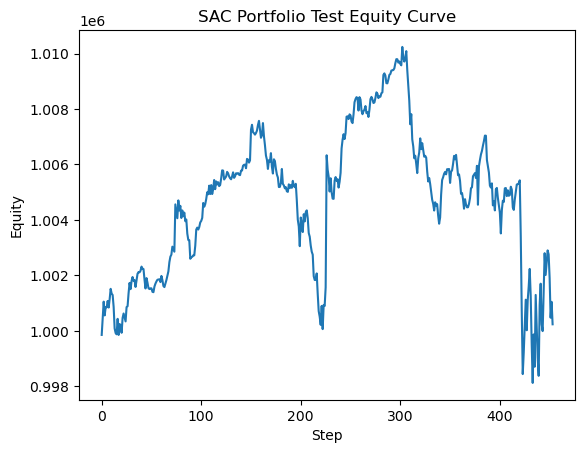

NameError: name 'eval_envs' is not defined

In [16]:
obs = eval_env.reset()
equities = []
rewards = []

for _ in range(500):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = eval_env.step(action)
    equities.append(info[0].get("equity"))
    rewards.append(reward[0])
    if done[0]:
        break

print("Final equity:", equities[-1])
print("Mean reward:", np.mean(rewards))



import matplotlib.pyplot as plt
plt.plot(equities)
plt.title("SAC Portfolio Test Equity Curve")
plt.xlabel("Step")
plt.ylabel("Equity")
plt.show()


print(eval_envs[0])


In [17]:
from stable_baselines3 import SAC

model = SAC.load("models/sac_portfolio")
obs = eval_env.reset()

equities = []
for _ in range(len(test_panel)):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = eval_env.step(action)
    equities.append(info["equity"])
    if done:
        break



TypeError: list indices must be integers or slices, not str